In [2]:
# Import dependancies
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle
import umap
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px


2023-08-09 20:57:11.912298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load CSV data
data = pd.read_csv('preprocessed_training_data.csv')

In [4]:
data.head()

,TotalReads(M),%ReadsPanel,1000x,500x,200x,100x,50x,25x,DupFrac,LowCovRegions,...,SophiaGIStatus_1,SophiaGIStatus_2,SophiaGIStatus_3,SophiaGIStatus_4,Purity,PurityPloidyRatio,SOPHiAGIIndex,ResNoise,SignalNoiseRatio,Agreement2
0,7.3,0.19,0.01,0.05,0.49,0.84,0.98,1.0,0.67,769,...,1,0,0,0,20.0,0.285591,3.2,0.13,2.95,1
1,7.3,0.24,0.02,0.12,0.73,0.97,1.00,1.0,0.68,580,...,0,1,0,0,30.0,0.200000,-15.7,0.11,2.91,1
2,9.6,0.36,0.41,0.97,1.00,1.00,1.00,1.0,0.58,7,...,0,1,0,0,20.0,0.150000,-4.6,0.10,1.64,1
3,8.9,0.37,0.16,0.71,0.99,1.00,1.00,1.0,0.71,33,...,0,1,0,0,20.0,0.170000,-4.6,0.09,3.49,1
4,8.6,0.42,0.02,0.46,1.00,1.00,1.00,1.0,0.81,15,...,0,1,0,0,60.0,0.200000,-8.2,0.11,2.18,1


In [5]:
# Separate features and target
X = data.iloc[:, :-1]
y = data['Agreement2']

In [6]:
X.columns

Index(['TotalReads(M)', '%ReadsPanel', '1000x', '500x', '200x', '100x', '50x',
       '25x', 'DupFrac', 'LowCovRegions', 'QAStatus_High', 'QAStatus_Low',
       'QAStatus_Medium', 'Gene_BRCA1', 'Gene_BRCA2', 'SophiaGIStatus_1',
       'SophiaGIStatus_2', 'SophiaGIStatus_3', 'SophiaGIStatus_4', 'Purity',
       'PurityPloidyRatio', 'SOPHiAGIIndex', 'ResNoise', 'SignalNoiseRatio'],
      dtype='object')

In [7]:
y[:20].to_list()

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Define which columns need standard scaling
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [10]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
    ])

In [11]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [12]:
# Create a pipeline combining preprocessing and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

In [13]:
# Make prediction
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=5)

## Evaluate

In [14]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))
print("\nAccuracy:", accuracy_score(y_train, y_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

Confusion Matrix:
[[ 9 17]
 [ 6 79]]

Accuracy: 0.7927927927927928

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.35      0.44        26
           1       0.82      0.93      0.87        85

    accuracy                           0.79       111
   macro avg       0.71      0.64      0.66       111
weighted avg       0.77      0.79      0.77       111



In [15]:
# Fit the model on the full training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['TotalReads(M)', '%ReadsPanel', '1000x', '500x', '200x', '100x', '50x',
       '25x', 'DupFrac', 'LowCovRegions', 'QAStatus_High', 'QAStatus_Low',
       'QAStatus_Medium', 'Gene_BRCA1', 'Gene_BRCA2', 'SophiaGIStatus_1',
       'SophiaGIStatus_2', 'SophiaGIStatus_3', 'SophiaGIStatus_4', 'Purity',
       'PurityPloidyRatio', 'SOPHiAGIIndex', 'ResNoise', 'SignalNoiseRatio'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [16]:
# Random Forests in sklearn will automatically calculate feature importance
importances = pipeline.named_steps['classifier'].feature_importances_
# We can sort the features by their importance
sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True)

[(0.13357929597530915, 'SOPHiAGIIndex'),
 (0.09027659710586787, 'SophiaGIStatus_4'),
 (0.08527411724623389, 'DupFrac'),
 (0.08002666845469916, 'TotalReads(M)'),
 (0.06728600984488674, 'SignalNoiseRatio'),
 (0.06394632635090594, '%ReadsPanel'),
 (0.06361155363903502, 'QAStatus_Low'),
 (0.05713019054352089, 'ResNoise'),
 (0.03989292585217518, '1000x'),
 (0.03979766231323775, 'PurityPloidyRatio'),
 (0.03591191134035451, '500x'),
 (0.03438814112550864, 'SophiaGIStatus_1'),
 (0.03117098530741052, 'LowCovRegions'),
 (0.027772595860092144, 'SophiaGIStatus_2'),
 (0.02753539131949545, 'SophiaGIStatus_3'),
 (0.027227672126828625, 'Purity'),
 (0.018883093850154527, 'Gene_BRCA1'),
 (0.01873456237558426, '200x'),
 (0.014925814111287078, '100x'),
 (0.011633867298269963, 'QAStatus_High'),
 (0.009869273128176832, '50x'),
 (0.00841701431303947, 'QAStatus_Medium'),
 (0.006565391161010356, 'Gene_BRCA2'),
 (0.006142939356915995, '25x')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

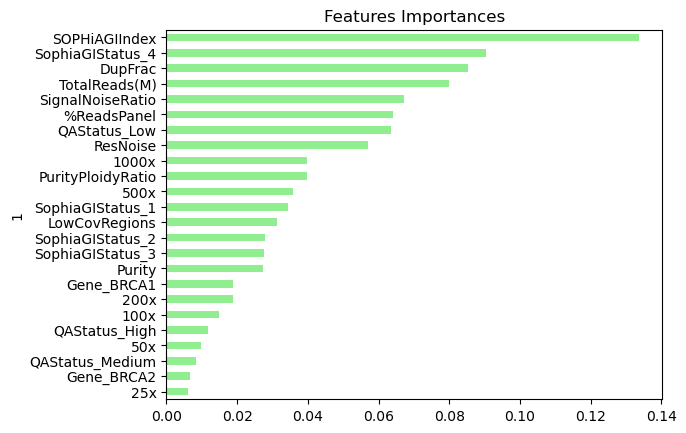

In [17]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [18]:
# Save the trained model to a file
with open('trained_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

In [19]:
# Apply UMAP
umap_model = umap.UMAP(n_neighbors=11, n_components=2)
X_umap = umap_model.fit_transform(X_train)

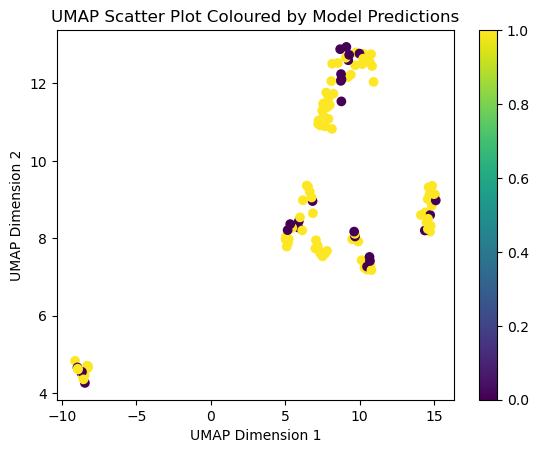

In [20]:
# Create a scatter plot with colors based on predictions
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='viridis')

# Add colorbar for reference
plt.colorbar()

# Add title and labels
plt.title("UMAP Scatter Plot Coloured by Model Predictions")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")

# Show the plot
plt.show()

In [21]:
# Convert UMAP-transformed data to a DataFrame
umap_df = pd.DataFrame(X_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])

In [22]:

# Create an interactive scatter plot using Plotly
fig = px.scatter(umap_df, x='UMAP Dimension 1', y='UMAP Dimension 2', hover_name=umap_df.index)

# Show the plot
fig.show()